# AI 688-001: Image and Vision Computing

## Homework Project #3: Numeric Character Recognition (NCR) Kaggle Competitive

#### Masheha Rashid (LID ID: 100687256)

**Citation**:
Akaash Tripathi. (2024). Numeric Character Recognition (NCR). Kaggle. https://kaggle.com/competitions/ncr

#### **Competition Description**
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

#### **Goal**
The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is. For every in the test set, you should predict the correct label.

#### **Metric**
This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

### I. Importing Libraries/Packages

In [1]:
# Libraries for accessing/displaying the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Libraries for building the classification model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

### II. Loading The Dataset

"The data files **train.csv** and **test.csv** contain gray-scale images of hand-drawn digits, from zero through nine."

"Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive."

"Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero)."

In [2]:
# Accessing the training dataset

trainData = pd.read_csv('/content/ncr/train.csv')
print(trainData.shape)
trainData.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Accessing the testing dataset

testData = pd.read_csv('/content/ncr/test.csv')
print(testData.shape)
testData.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## III. Preprocessing the Data

In [4]:
# Extracting and removing the image labels from the training data

img_labels = trainData.label
trainData = trainData.drop('label', axis=1)

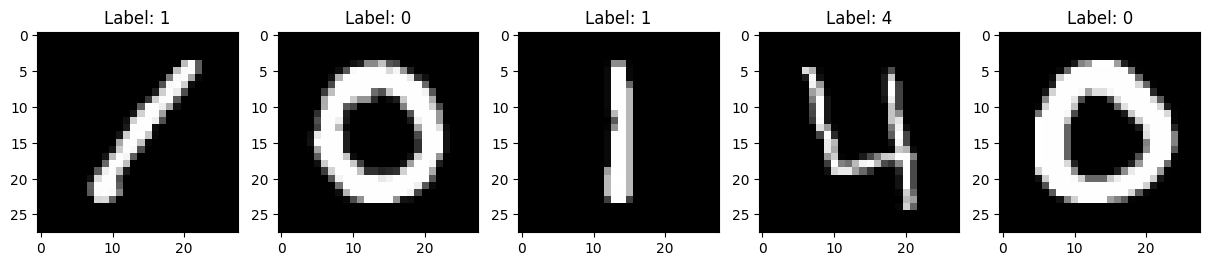

In [5]:
# Function to visualize training images
def visualize_training_images(data, labels, start_index, end_index):
    images = data.iloc[start_index:end_index].values
    images = images.reshape(-1, 28, 28)

    fig, axes = plt.subplots(1, end_index - start_index, figsize=(15, 3))

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {labels.iloc[start_index + i]}")
        ax.axis('on')

# Visualize first five training images
visualize_training_images(trainData, img_labels, 0, 5)

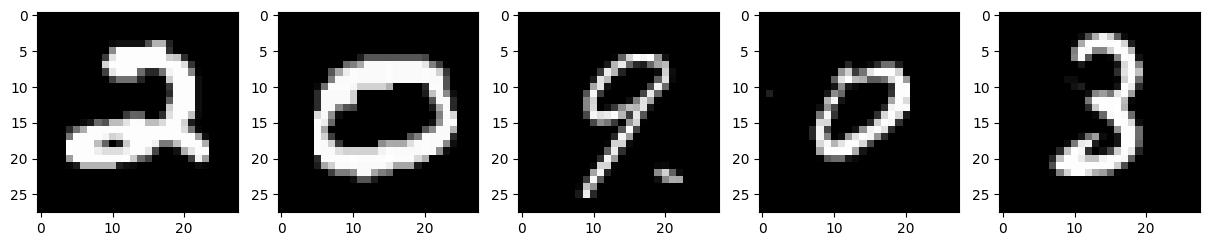

In [6]:
# Function to visualize testing images
def visualize_testing_images(data, start_index, end_index):
    images = data.iloc[start_index:end_index].values
    images = images.reshape(-1, 28, 28)

    fig, axes = plt.subplots(1, end_index - start_index, figsize=(15, 3))

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('on')

# Visualize the first five testing images
visualize_testing_images(testData, 0, 5)

In [7]:
# Function that preprocesses the input data for the model

def img_prep(im):

  # Number of images in the dataset
  num_img = im.shape[0]

  # Contains the pixel values of all the images (2D array)
  X_array = im.values[:,:]

  # Reshapes the 2D array into a 4D array
  X_reshape = X_array.reshape(num_img, 28, 28, 1)

  # Normalizes the pixel values to the range [0, 1]
  X_prep = X_reshape / 255

  return X_prep

In [8]:
# Split the training data into training and validation sets

X = img_prep(trainData)
y = pd.get_dummies(img_labels)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training X:', X_train.shape)
print('Validation X:,', X_valid.shape)
print('Training Y:', y_train.shape)
print('Validation Y:,', y_valid.shape)

Training X: (33600, 28, 28, 1)
Validation X:, (8400, 28, 28, 1)
Training Y: (33600, 10)
Validation Y:, (8400, 10)


## IV. Building the Convolutional Neural Network (CNN) Model

In [9]:
model = Sequential([
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(128, kernel_size=(5, 5), padding='same', activation='relu'),
    MaxPooling2D(4, 4),
    Dropout(0.25),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 3, 3, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

## V. Training the CNN Model
Training lasted for 56 minutes and 23 seconds.

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=128, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
263/263 [==============================] - 229s 866ms/step - loss: 0.3429 - accuracy: 0.8996 - val_loss: 0.0963 - val_accuracy: 0.9713
Epoch 2/15
263/263 [==============================] - 226s 861ms/step - loss: 0.0848 - accuracy: 0.9742 - val_loss: 0.0536 - val_accuracy: 0.9839
Epoch 3/15
263/263 [==============================] - 224s 851ms/step - loss: 0.0599 - accuracy: 0.9816 - val_loss: 0.0501 - val_accuracy: 0.9833
Epoch 4/15
263/263 [==============================] - 225s 854ms/step - loss: 0.0448 - accuracy: 0.9852 - val_loss: 0.0435 - val_accuracy: 0.9864
Epoch 5/15
263/263 [==============================] - 227s 863ms/step - loss: 0.0381 - accuracy: 0.9882 - val_loss: 0.0373 - val_accuracy: 0.9889
Epoch 6/15
263/263 [==============================] - 227s 863ms/step - loss: 0.0314 - accuracy: 0.9907 - val_loss: 0.0301 - val_accuracy: 0.9904
Epoch 7/15
263/263 [==============================] - 225s 855ms/step - loss: 0.0264 - accuracy: 0.9915 - val_loss: 0.0323 -

## VI. Visualizing the Training Process

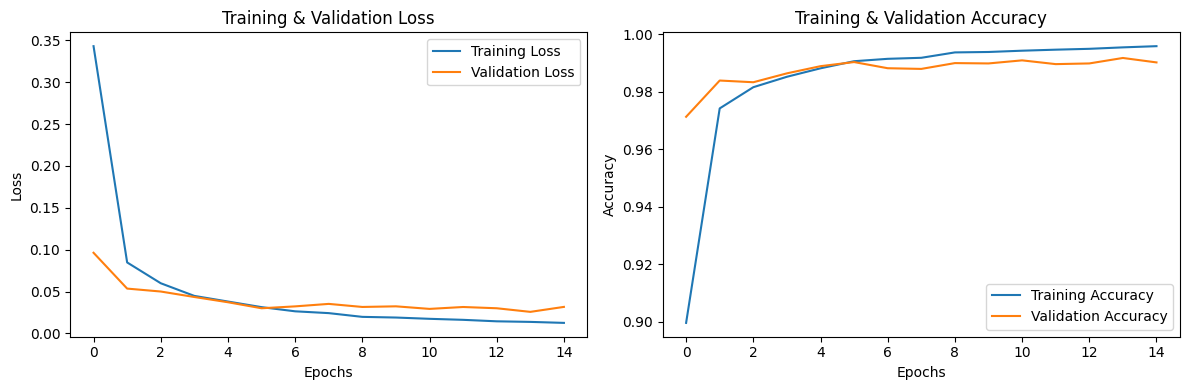

In [11]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

After 15 epochs of training, the model's training and validation losses decreased while, the training and validation accuracies increased. Therefore, the CNN model trained well.

## VII. Evaluating the Model's Performance

In [22]:
# Make predictions on the validation set
y_pred_prob = model.predict(X_valid)

# Convert predicted probabilities to labels
pred_labels = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded labels back to categorical labels
original_labels = np.argmax(y_valid.values, axis=1)

# Calculate accuracy on validation set
accuracy = accuracy_score(original_labels, pred_labels)

print(f"Accuracy on validation data: {accuracy * 100:.2f}%")

263/263 [==============================] - 16s 60ms/step
Accuracy on validation data: 98.89%


In [23]:
# Compare predicted labels with original labels
comparison_df = pd.DataFrame({'Original_Labels': original_labels, 'Predicted_Labels': pred_labels})

# Add a column to indicate whether each prediction is correct or not
comparison_df['Prediction_Correct'] = comparison_df['Original_Labels'] == comparison_df['Predicted_Labels']

comparison_df

,Original_Labels,Predicted_Labels,Prediction_Correct
0,8,8,True
1,1,1,True
2,9,9,True
3,9,9,True
4,8,8,True
...,...,...,...
8395,4,4,True
8396,9,9,True
8397,3,3,True
8398,0,0,True


In [24]:
# Filter rows where the predictions are incorrect
incorrect_predictions = comparison_df[comparison_df['Prediction_Correct'] == False]

print("Incorrect Predictions:")
incorrect_predictions

Incorrect Predictions:


,Original_Labels,Predicted_Labels,Prediction_Correct
64,8,5,False
77,9,7,False
139,7,4,False
335,0,6,False
353,7,1,False
...,...,...,...
8151,8,5,False
8193,6,5,False
8286,8,2,False
8321,8,2,False


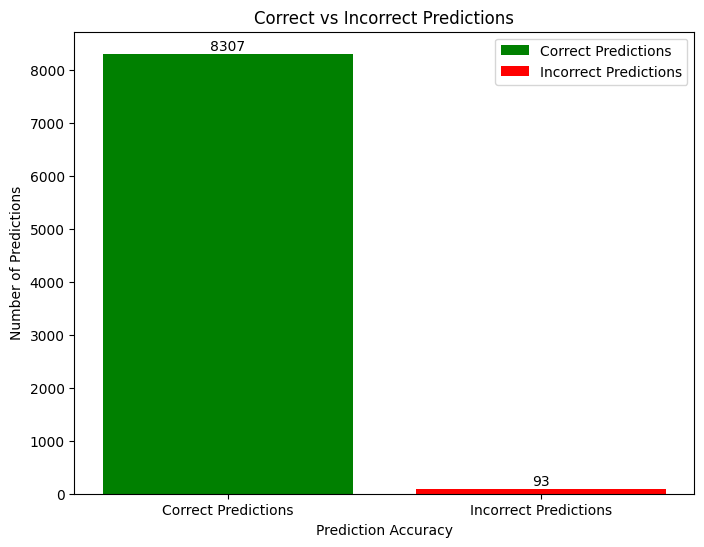

In [25]:
# Creating a bar graph to visualize the correct and incorrect predictions

labels = ['Correct Predictions', 'Incorrect Predictions']
values = [len(comparison_df) - len(incorrect_predictions), len(incorrect_predictions)]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['green', 'red'])
plt.xlabel('Prediction Accuracy')
plt.ylabel('Number of Predictions')
plt.title('Correct vs Incorrect Predictions')

# Add the amount of correct and incorrect predictions on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.legend(bars, labels, loc='upper right')

plt.show()

Since the training process went sucessful, the model performed well on the validation data. The model has an **98.89%** accuracy and only misclassified **93** number images.

## VIII. Applying the Model on the Testing Data

In [26]:
final_results = pd.read_csv('/content/ncr/sample_submission.csv')
print(final_results.shape)
final_results.head()

(28000, 2)


,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [30]:
X_test = img_prep(testData)

y_pred = model.predict(X_test)

875/875 [==============================] - 55s 63ms/step


In [31]:
df = pd.DataFrame(data = y_pred)

test_labels = df.idxmax(axis=1)

final_results['Label'] = np.array(test_labels)

final_results

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [32]:
# Save final_results to a CSV file
final_results.to_csv('final_results.csv', index=False)